# Markets physics - TP 3.1 : Minority game with variable number of agents

**Hugo Yeremian - Martín Pasche**

---

## Importing and defining useful functions

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from numba import njit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from tqdm import tqdm

### Game running functions

In [2]:
def create_variables(seed, iterations, Ns, P, Np, init_mu_U, init_std_U):
    """
    Create variables for the game using efficient data types.
    """
    np.random.seed(seed)

    # dimensions : state using float32 for efficiency
    Omega = np.random.normal(0, Np, P).astype(np.float32)

    # dimensions : i , mu
    # Generate values only 0 and 1 and map them to -1 and 1,
    # then convert to int8 to save memory.
    a = (np.random.randint(0, 2, size=(Ns, P)) * 2 - 1).astype(np.int8)
    
    # Initialize accumulated performance using float32
    U = np.empty((Ns, iterations + 1), dtype=np.float32)
    U[:, 0] = np.random.normal(init_mu_U, init_std_U, size=Ns).astype(np.float32)
    U[:, 1:] = 0.0  # filling rest with 0
    
    # Matrix of actions over time, using float32
    A = np.zeros(iterations, dtype=np.float32)
    
    # Initial market state, using uint8 assuming P is small (change to int32 if needed)
    mu = np.random.randint(0, P, dtype=np.uint8)
    
    return a, Omega, U, A, mu


def create_variables_continuous_a(seed, iterations, Ns, P, Np, init_mu_U, init_std_U):
    np.random.seed(seed)
    
    Omega = np.random.normal(0, Np, P).astype(np.float32)
    
    # Estrategias continuas en lugar de ±1
    a = np.random.normal(0, 1, size=(Ns, P)).astype(np.float32)
    
    U = np.empty((Ns, iterations + 1), dtype=np.float32)
    U[:, 0] = np.random.normal(init_mu_U, init_std_U, size=Ns).astype(np.float32)
    U[:, 1:] = 0.0
    
    A = np.zeros(iterations, dtype=np.float32)
    mu = np.random.randint(0, P, dtype=np.uint8)
    
    return a, Omega, U, A, mu

@njit
def run_game(a, mu, Omega, U, A, eps, iterations):
    P = Omega.shape[0]
    Ns = a.shape[0]
    mu = mu
    
    for t in range(iterations):
        n = np.where(U[:, t] > 0, 1, 0)
        actions = a[:, mu] * n
        A[t] = Omega[mu] + actions.sum()
        
        U[:, t+1] = U[:, t] - a[:, mu] * A[t] - eps 
        # mu = np.random.randint(0, P)
        add_val = 1 if A[t] > 0 else 0
        mu = (2 * mu + add_val) % P
        
    return A, U


@njit
def run_game_with_mu(a, Omega, U, A, eps, mu, iterations):
    P = Omega.shape[0]
    Ns = a.shape[0]
    mu_hist = np.empty(iterations, dtype=np.int32)
    
    for t in range(iterations):
        mu_hist[t] = mu
        n = (U[:, t] > 0).astype(np.int32)
        actions = a[:, mu] * n
        A[t] = Omega[mu] + actions.sum()
        U[:, t+1] = U[:, t] - a[:, mu] * A[t] - eps
        #mu = np.random.randint(0, P)
        add_val = 1 if A[t] > 0 else 0
        mu = (2 * mu + add_val) % P
    
    return A, mu_hist

### Functions for metric calculations

In [3]:
def compute_metrics(A, mu_history, P, burnin=0):
    # Use only after burnin, that is, when it is stationary
    A = A[burnin:]
    mu_history = mu_history[burnin:]
    
    sigma2 = np.mean(A**2)

    # Previsibility
    A_mu = np.zeros(P)
    counts = np.zeros(P)
    for t in range(len(A)):
        mu = mu_history[t]
        A_mu[mu] += A[t]
        counts[mu] += 1
    
    A_mu_avg = A_mu / np.maximum(counts, 1)  # Avoid division by zero
    H0 = np.sum(A_mu_avg**2) / P
    
    return sigma2, H0


def estimate_sigma_H0_for_ns(ns, P=20, Np=20, eps=0.01, reps=100):
    sigma_vals = []
    H0_vals = []

    iterations = int(400 * P / eps)
    burnin = int(200 * P / eps)
    
    Ns = int(ns * P)
    for r in range(reps):
        seed = r + 123  # diferent seed for each repetition
        a, Omega, U, A, mu = create_variables(seed, iterations, Ns, P, Np, 0.1, 0.05)
        A_out, mu_hist = run_game_with_mu(a, Omega, U, A, eps, mu, iterations)
        sigma2, H0 = compute_metrics(A_out, mu_hist, P, burnin)
        sigma_vals.append(sigma2 / P)
        H0_vals.append(H0 / P)
    
    return np.mean(sigma_vals), np.mean(H0_vals)

---

## Verify amplitud of $A(t)$ explose over time if the number of speculators is enoughly large, with P and $N_p$ fixed.

First, we do a simple check of the code, to see if it working without errors.

Number of states: 16
State of stationarity: 32000.0


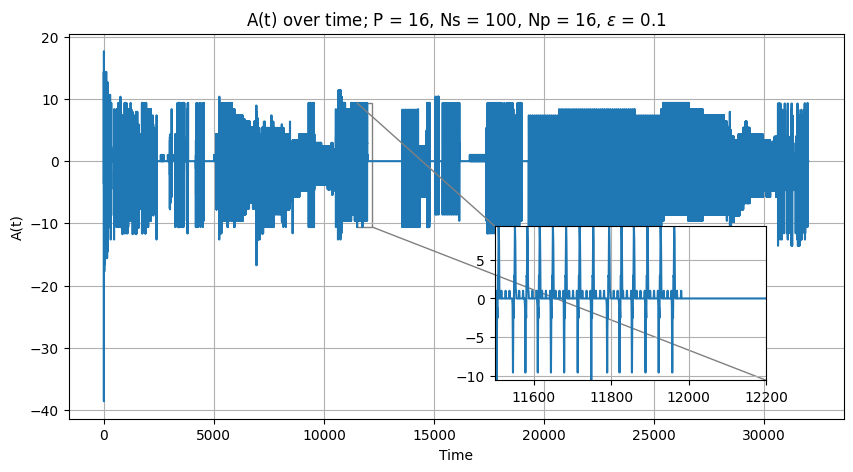

In [4]:
# Parameter set up
P = 16
Np = 16
Ns = 100
eps = 0.1

init_mu_U = 0.1
init_std_U = 0.05

print("Number of states:", P)
print("State of stationarity:", 200 * P / eps)

iterations = int( 200 * P / eps ) 
seed = 42

a, Omega, U, A, mu = create_variables(seed, iterations, Ns, P, Np, init_mu_U, init_std_U)

A, U = run_game(a, mu, Omega, U, A, eps, iterations)


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(A)
ax.set_title(r"A(t) over time; P = {}, Ns = {}, Np = {}, $\epsilon$ = {}".format(P, Ns, Np, eps))
ax.set_xlabel("Time")
ax.set_ylabel("A(t)")
ax.grid()


axins = inset_axes(
    ax,
    width="35%",         # Width of inset
    height="40%",        # Height of inset
    loc="lower left",    # Where the anchor point is on the main plot
    bbox_to_anchor=(0.55, 0.1, 1, 1),  # Manual position of the anchor point
    bbox_transform=ax.transAxes,  # So (x, y) is relative to the axes (0 to 1)
    borderpad=0
)
x1, x2 = 11500, 12200  # zoom range
y1, y2 = min(A[x1:x2]), max(A[x1:x2])  # limits

axins.plot(A)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid()

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()


Now, we compare the value of $A(t)$ for different values of $N_s$:

Number of states: 15
State of stationarity: 60000.0


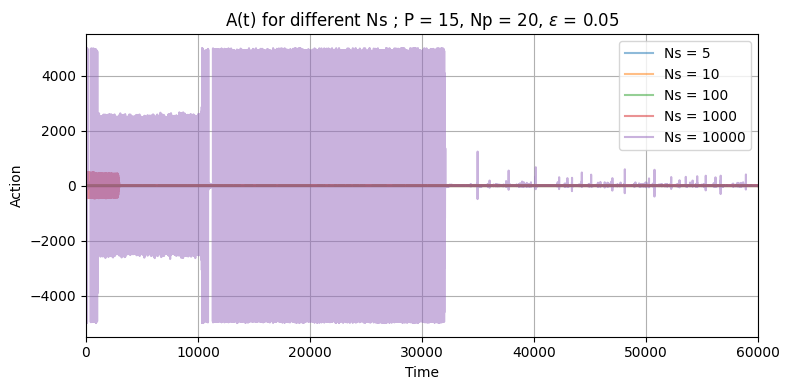

In [74]:
# Parameter set up
P = 15
Np = 20
eps = 0.05

init_mu_U = 0.1
init_std_U = 0.05

print("Number of states:", P)
print("State of stationarity:", 200 * P / eps)

iterations = int(  200 * P / eps ) 
#iterations = 10_000
seed = 41


plt.figure(figsize=(8,4))
for Ns in [5, 10, 100, 1000, 10_000]:
        
        # Generate vectors and matrices for the game
        a, Omega, U, A, mu = create_variables(
                            seed, iterations, Ns, P, 
                            Np, init_mu_U, init_std_U)
    
        A, U = run_game(a, mu, Omega, U, A, eps, iterations)
    
        plt.plot(A, label= f"Ns = {Ns}", alpha = 0.5)      
        
plt.xlabel("Time")
plt.ylabel("Action")
plt.title(r"A(t) for different Ns ; P = {}, Np = {}, $\epsilon$ = {}".format(P, Np, eps))
plt.xlim(0, iterations)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

We can see that the value of the amplitude explodes with $N_s$ being higher. This is expected, as they are bringing more volatility to the market, since there will be more impact from the agents than from the producers.

After a while, the system stabilizes, keeping only those agents that are able to win the game. This is a consequence of the fact that the agents are always searching to maximize their profit, and the ones that are not able to gain money will be eliminated from the game.

---

## Measure the values of $\sigma^2 = <A^2>$ and $H_0 =  \sum_{\mu} \frac{<A | \mu>^2}{P}$.

Trace $\sigma^2 / P$ and $H_0 /P$ in function of $n_s = \frac{N_s}{P}$ fixing the value of $P$ and making $N_s$ vary (10 - 15 points is enough). The average is taken over many simulations of the game with each of the game parameters.

In [15]:
#ns_values = np.linspace(0.1, 100, 5)
ns_values = np.logspace(np.log10(0.1), np.log10(100), 10)
sigma_list = []
H0_list = []

P = 15
Np = 15
eps = 0.1

for ns in ns_values:
    print(f"Running ns = {ns:.2f}")
    sigma, H0 = estimate_sigma_H0_for_ns(ns, P, Np, eps, reps=100)
    sigma_list.append(sigma)
    H0_list.append(H0)

Running ns = 0.10
Running ns = 0.22
Running ns = 0.46
Running ns = 1.00
Running ns = 2.15
Running ns = 4.64
Running ns = 10.00
Running ns = 21.54
Running ns = 46.42
Running ns = 100.00


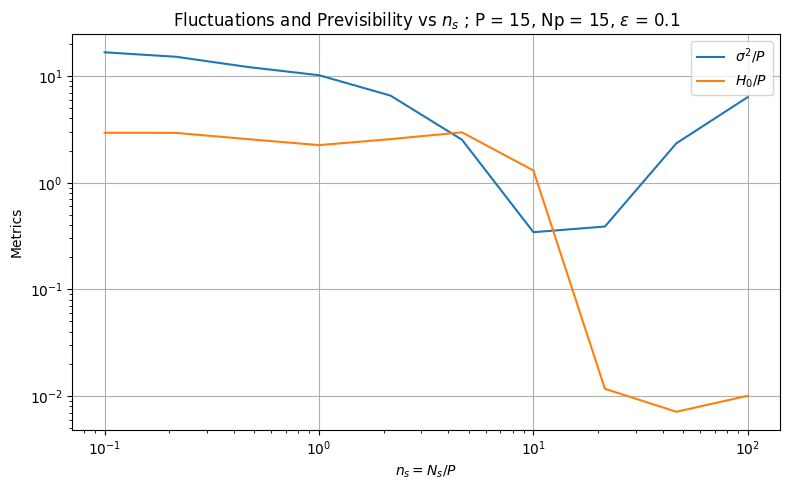

In [17]:
plt.figure(figsize=(8,5))
plt.plot(ns_values, sigma_list, label=r"$\sigma^2 / P$")
plt.plot(ns_values, H0_list, label=r"$H_0 / P$")
plt.xscale("log")
plt.yscale('log')
plt.xlabel(r"$n_s = N_s / P$")
plt.ylabel("Metrics")
plt.title(r"Fluctuations and Previsibility vs $n_s$ ; P = {}, Np = {}, $\epsilon$ = {}".format(P, Np, eps))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From the graph, we can see that the larger the amount of speculators, the lower the previsibility of the market. This is a consequence of the fact that the speculators are trying to maximize their profits, which in the end, reduces $A(t)$ and thus, reducing $H_0$. 

Meanwhile, for the volatility, the lower the amount of agents, the higher the volatility. This is thanks to the effects of the agents, since there aren't enough speculators to impact greatly the market. At some point, the speculators are able to profit from the market, which in the end reduces the volatility. But after some critical point, the volatility starts to increase again, since the agents starts having too much impact in the market, making it unpredictable, since we would need to know the intentions of the other agents to be able to predict the market.

## Verify that $H_0$ is never zero if $\epsilon > 0$

For this, we need to test out different parameters of the system, get the minimum value of $H_0$ and see if they are different from zero. Lastly, we need to check the value of the previsibility if $\epsilon$ is equal to zero.

In [ ]:
P_list = 15
Np = 15
eps_list = [0, 0.01, 0.1]
ns_list = np.linspace(1, 50, 5) 

records = []
seed = 10          # now im not looking for reproducibility
simulations = 5

for eps in tqdm(eps_list):
    iterations = int(400 * P / eps) if eps > 0 else 60_000
    burnin = int(200 * P / eps) if eps > 0 else 60_000 // 2
    for ns in ns_list:
        Ns = int(ns * P)
        H0_vals = []
        for r in range(simulations):
            a, Omega, U, A, mu = create_variables(seed, iterations, Ns, P, Np, 0.1, 0.05)
            A_out, mu_hist = run_game_with_mu(a, Omega, U, A, eps, mu, iterations)
            _, H0 = compute_metrics(A_out, mu_hist, P, burnin)
            H0_vals.append(H0)
            seed += 1
        record = {
            "P": P,
            "Np": Np,
            "eps": eps,
            "ns": ns,
            "Ns": Ns,
            "H0_min": np.min(H0_vals),
            "H0_mean": np.mean(H0_vals)
        }
        records.append(record)

100%|██████████| 3/3 [01:32<00:00, 30.74s/it]


In [12]:
df = pd.DataFrame(records)
df.head()

,P,Np,eps,ns,Ns,H0_min,H0_mean
0,15,15,0.0,1.00,15,0.031360,61.279292
1,15,15,0.0,13.25,198,0.000006,0.102657
2,15,15,0.0,25.50,382,0.000010,0.000152
3,15,15,0.0,37.75,566,0.000005,0.000531
4,15,15,0.0,50.00,750,0.000007,0.000225


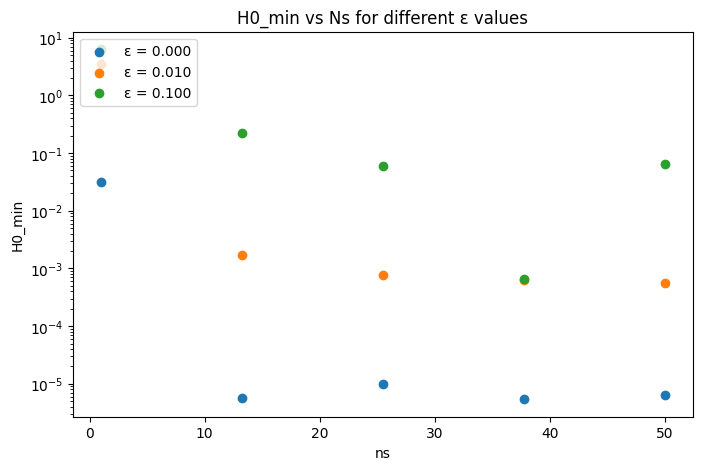

In [14]:
plt.figure(figsize=(8, 5))
plt.title("H0_min vs Ns for different ε values")

for eps_val in df["eps"].unique():
    df_sub = df[df["eps"] == eps_val]
    plt.scatter(df_sub["ns"], df_sub["H0_min"], label=f"ε = {eps_val:.3f}")

plt.ylabel("H0_min")
plt.xlabel('ns')
plt.yscale('log')
plt.legend(loc='upper left')
plt.show()

We observe that the smallest values of $H_0$ are not strictly equal to zero. This can be attributed to numerical approximations and the fact that we are working with discrete integer-based variables. Nevertheless, the lowest values of $H_0$ are consistently obtained for the smallest values of ϵ, which aligns with theoretical expectations.

Indeed, when 𝜖 = 0, there is no transaction cost, so all agents participate in the market. This maximizes the number of active agents available to exploit and anticipate the market signal, thereby minimizing previsibility.

However, when 𝜖 > 0, only agents with sufficiently good performance remain active. As a result, the number of active agents decreases, which in turn increases $H_0$. In this case, the system can be understood as minimizing previsibility under a constraint imposed by transaction costs.

This relationship is captured by the approximate relation:
$$
𝐻_0 ≈2𝜖 𝐸(N_{active}) 
$$
which reflects a trade-off: the agents seek to minimize previsibility, but their activity is penalized by transaction costs ϵ. Thus, as ϵ increases, previsibility cannot reach zero due to the reduction in market participation.

## Take $a_{i,j} \sim P(a)$ such that $E[a_{i,j}] = 0$ and $E[a_{i,j}^2] = 1$. Do you see any difference with the previous case?

In [77]:
Np = 15
P = 15
eps = 0.1
Ns = 1000

iterations = int(400 * P / eps)
burnin = int(200 * P / eps)

H_results_binary = []
H_results_continuous = []

vol_results_binary = []
vol_results_continuous = []

simulations = 100

for r in tqdm(range(simulations), desc="Simulations"):
    seed = 100 + r

    # Binaria
    a1, Omega, U1, A1, mu1 = create_variables(seed, iterations, Ns, P, Np, 0.1, 0.05)
    A1_out, mu1_hist = run_game_with_mu(a1, Omega, U1, A1, eps, mu1, iterations)
    vol1, H01 = compute_metrics(A1_out, mu1_hist, P, burnin)
    H_results_binary.append(H01)
    vol_results_binary.append(vol1)

    # Continua
    a2, Omega, U2, A2, mu2 = create_variables_continuous_a(seed, iterations, Ns, P, Np, 0.1, 0.05)
    A2_out, mu2_hist = run_game_with_mu(a2, Omega, U2, A2, eps, mu2, iterations)
    vol2, H02 = compute_metrics(A2_out, mu2_hist, P, burnin)
    H_results_continuous.append(H02)
    vol_results_continuous.append(vol2)

Simulations: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


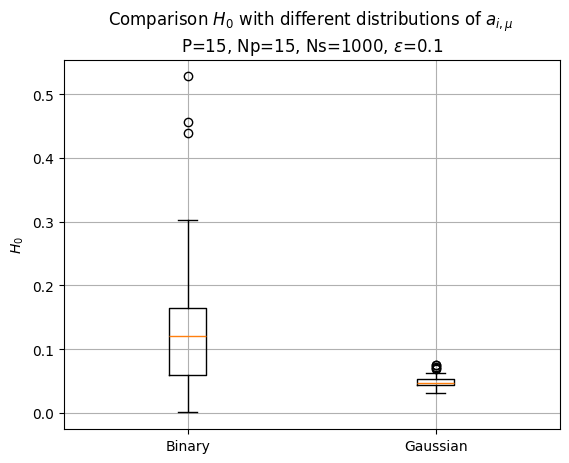

In [78]:
plt.boxplot([H_results_binary, H_results_continuous], tick_labels=['Binary', 'Gaussian'])
plt.title(
    "Comparison $H_0$ with different distributions of $a_{i,\\mu}$ \n" + 
    "P={}, Np={}, Ns={}, $\\epsilon$={}".format(
        P, Np, Ns, eps))
plt.ylabel(r"$H_0$")
plt.grid(True)
plt.show()

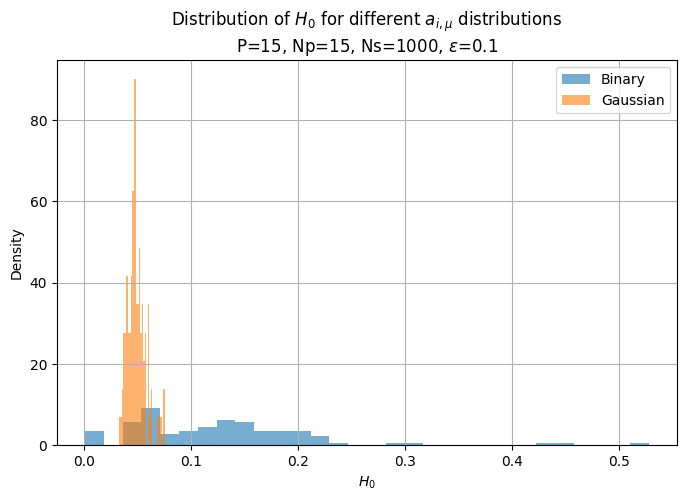

In [79]:
plt.figure(figsize=(8,5))

plt.hist(H_results_binary, bins=30, alpha=0.6, label="Binary", density=True)
plt.hist(H_results_continuous, bins=30, alpha=0.6, label="Gaussian", density=True)

plt.title(
    "Distribution of $H_0$ for different $a_{i,\\mu}$ distributions\n" +
    "P={}, Np={}, Ns={}, $\\epsilon$={}".format(P, Np, Ns, eps)
)
plt.xlabel(r"$H_0$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [80]:
Np = 15
P = 15
eps = 0.1
Ns = 100

iterations = int(400 * P / eps)
burnin = int(200 * P / eps)

H_results_binary = []
H_results_continuous = []

vol_results_binary = []
vol_results_continuous = []

simulations = 100

for r in tqdm(range(simulations), desc="Simulations"):
    seed = 100 + r

    # Binaria
    a1, Omega, U1, A1, mu1 = create_variables(seed, iterations, Ns, P, Np, 0.1, 0.05)
    A1_out, mu1_hist = run_game_with_mu(a1, Omega, U1, A1, eps, mu1, iterations)
    vol1, H01 = compute_metrics(A1_out, mu1_hist, P, burnin)
    H_results_binary.append(H01)
    vol_results_binary.append(vol1)

    # Continua
    a2, Omega, U2, A2, mu2 = create_variables_continuous_a(seed, iterations, Ns, P, Np, 0.1, 0.05)
    A2_out, mu2_hist = run_game_with_mu(a2, Omega, U2, A2, eps, mu2, iterations)
    vol2, H02 = compute_metrics(A2_out, mu2_hist, P, burnin)
    H_results_continuous.append(H02)
    vol_results_continuous.append(vol2)

Simulations: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


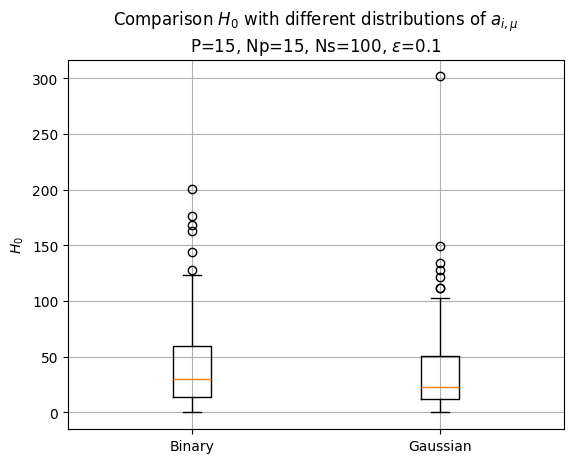

In [81]:
plt.boxplot([H_results_binary, H_results_continuous], tick_labels=['Binary', 'Gaussian'])
plt.title(
    "Comparison $H_0$ with different distributions of $a_{i,\\mu}$ \n" + 
    "P={}, Np={}, Ns={}, $\\epsilon$={}".format(
        P, Np, Ns, eps))
plt.ylabel(r"$H_0$")
plt.grid(True)
plt.show()

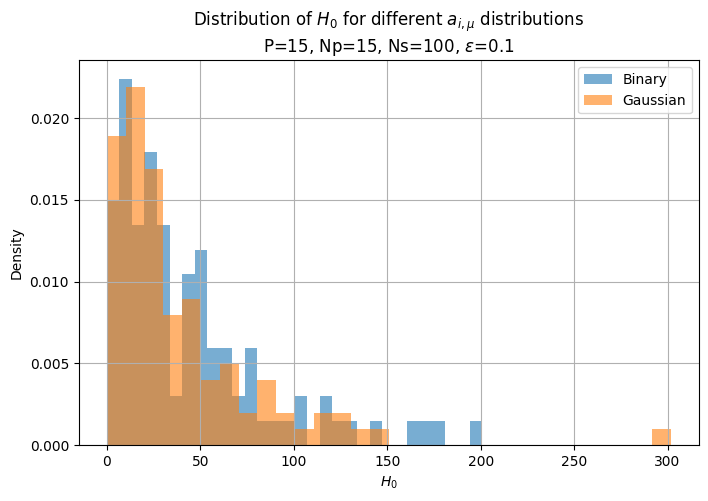

In [82]:
plt.figure(figsize=(8,5))

plt.hist(H_results_binary, bins=30, alpha=0.6, label="Binary", density=True)
plt.hist(H_results_continuous, bins=30, alpha=0.6, label="Gaussian", density=True)

plt.title(
    "Distribution of $H_0$ for different $a_{i,\\mu}$ distributions\n" +
    "P={}, Np={}, Ns={}, $\\epsilon$={}".format(P, Np, Ns, eps)
)
plt.xlabel(r"$H_0$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [83]:
ns_values = np.logspace(np.log10(0.1), np.log10(100), 10)
P = 15
Np = 15
eps = 0.1
simulations = 100
    
sigma_bin, H0_bin = [], []
sigma_gauss, H0_gauss = [], []

iterations = int(400 * P / eps)
burnin = int(200 * P / eps)

for ns in tqdm(ns_values, desc="Running simulations over ns"):
    Ns = int(ns * P)

    s_bin, h_bin = [], []
    s_gauss, h_gauss = [], []

    for r in range(simulations):
        seed = r + 100

        # Binary version
        a_bin, Omega, U, A, mu = create_variables(seed, iterations, Ns, P, Np, 0.1, 0.05)
        A_bin, mu_hist_bin = run_game_with_mu(a_bin, Omega, U, A, eps, mu, iterations)
        s2_bin, h0_bin = compute_metrics(A_bin, mu_hist_bin, P, burnin)
        s_bin.append(s2_bin / P)
        h_bin.append(h0_bin / P)

        # Gaussian version
        a_g, Omega, U, A, mu = create_variables_continuous_a(seed, iterations, Ns, P, Np, 0.1, 0.05)
        A_g, mu_hist_g = run_game_with_mu(a_g, Omega, U, A, eps, mu, iterations)
        s2_g, h0_g = compute_metrics(A_g, mu_hist_g, P, burnin)
        s_gauss.append(s2_g / P)
        h_gauss.append(h0_g / P)

    # Store the means
    sigma_bin.append(np.mean(s_bin))
    H0_bin.append(np.mean(h_bin))
    sigma_gauss.append(np.mean(s_gauss))
    H0_gauss.append(np.mean(h_gauss))

Running simulations over ns: 100%|██████████| 10/10 [05:25<00:00, 32.59s/it]


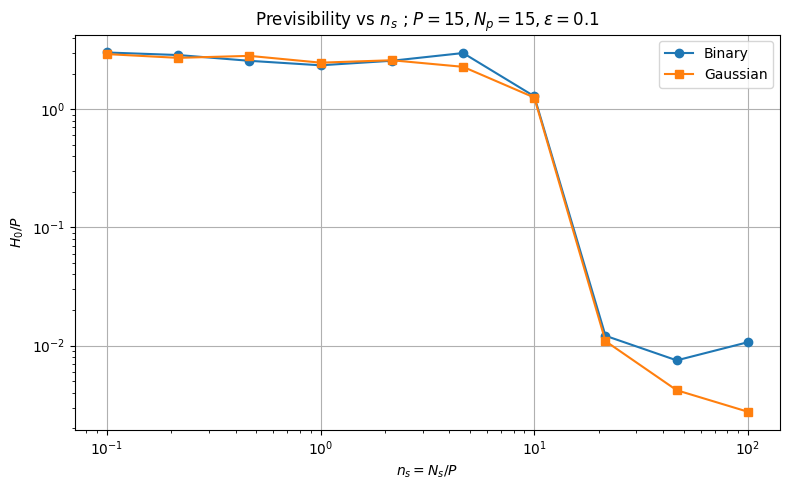

In [84]:
plt.figure(figsize=(8,5))
plt.plot(ns_values, H0_bin, marker='o', label="Binary")
plt.plot(ns_values, H0_gauss, marker='s', label="Gaussian")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$n_s = N_s / P$")
plt.ylabel(r"$H_0 / P$")
plt.title(r"Previsibility vs $n_s$ ; $P = {}, N_p = {}, \epsilon = {}$".format(P, Np, eps))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

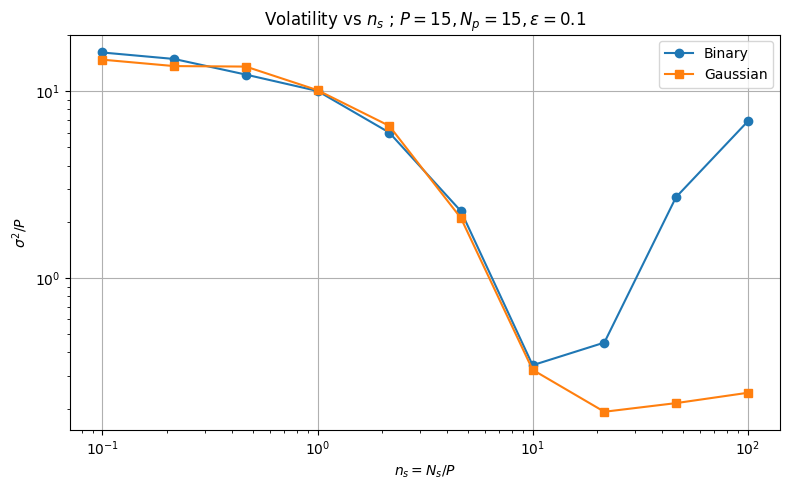

In [85]:
plt.figure(figsize=(8,5))
plt.plot(ns_values, sigma_bin, marker='o', label="Binary")
plt.plot(ns_values, sigma_gauss, marker='s', label="Gaussian")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$n_s = N_s / P$")
plt.ylabel(r"$\sigma^2 / P$")
plt.title(r"Volatility vs $n_s$ ; $P = {}, N_p = {}, \epsilon = {}$".format(P, Np, eps))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

From the previous graphs, we can see that both distributions behave very similar when the amount of speculators hasn't reached the critical point of minimum volatility. However, after this points, the volatility of the gaussian distribution decreases and stays lowers. The previsibility is also lower, with the simulations converging to the same value of $H_0$. This is showing that the agents, since they can take values not only between 0 and 1, they are able to take smaller actions, which in the ends have less impact in the market. Also, as the previsibility decreases, agents can also start looking for more complex strategies, strategies that can take profit from smaller $A(t)$ values, making the market converge to a more stable state, thus decreasing the volatility.